# Does Private Dataset have same structure as Train Dataset?
# Answer: YES
In normal Kaggle competitions, the `test.csv` that we download contains the private test dataset and the above question is easy to verify. In this competition, "Instant Gratification", the `test.csv` that we download does not contain the private test dataset. Can we still answer the question above? Yes.

The unique structure of the data has been explained [here][1]. (There are 512 partial datasets within the full dataset. And each partial dataset has a different set of approximately 40 important features as identified by different standard deviations.) We have observed that both the training dataset and public test dataset have this structure. Does the private dataset also have this structure? In this kernel, we probe the private dataset and confirm that it has the same structure.

The structure of the data encourages building 512 separate models. In this kernel we also show how to build a single model instead of 512. We will build a high scoring NN (LB 0.930) by using the wonderful starter code provided by Abhishek [here][2] (please upvote Abishek's kernel) and improved upon by Vladislav [here][3]. This is accomplished by removing the dataset's useless datablocks and converting the magic variable into categorical.

We will probe the Private LB and ask "Does the private test dataset have the same special structure as training and public test?". If the answer is "yes", this kernel will submit an ensemble of NN and SVC and score LB 0.950. If the answer is "no", this kernel will submit all zeros and score LB 0.500. To see the answer, view this kernel's LB score above.

[1]: https://www.kaggle.com/c/instant-gratification/discussion/92930
[2]: https://www.kaggle.com/abhishek/neural-network-with-embedding-layer
[3]: https://www.kaggle.com/speedwagon/neural-network-baseline

# Load Data

In [1]:
import numpy as np, pandas as pd, os, gc

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

train.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

## Find the useful data blocks
As described [here][1], the data appears to be `131072 = 512 * 256` blocks of data where some are **useful** and some are **useless**.

[1]: https://www.kaggle.com/c/instant-gratification/discussion/92930

In [2]:
# FIND STANDARD DEVIATION OF ALL 512*256 BLOCKS
useful = np.zeros((256,512))
for i in range(512):
    partial = train[ train['wheezy-copper-turtle-magic']==i ]
    useful[:,i] = np.std(partial.iloc[:,1:-1], axis=0)
# CONVERT TO BOOLEANS IDENTIFYING USEFULNESS
useful = useful > 1.5

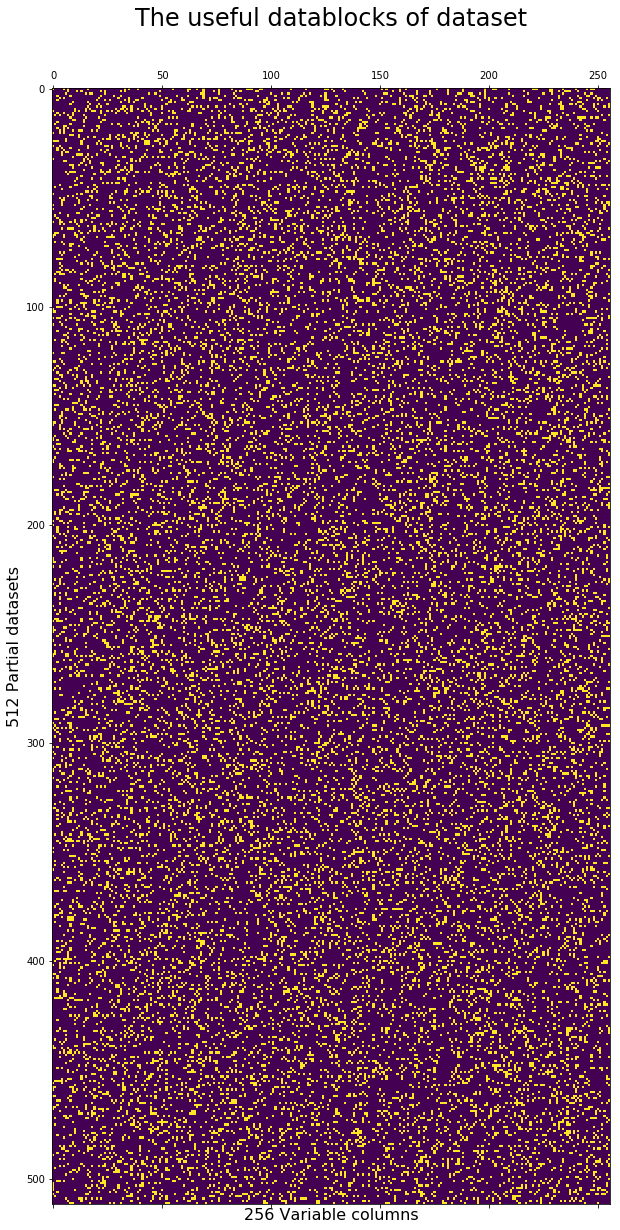

In [3]:
import matplotlib.pyplot as plt

# PLOT BOOLEANS OF USEFUL BLOCKS
plt.figure(figsize=(10,20))
plt.matshow(useful.transpose(),fignum=1)
plt.title('The useful datablocks of dataset', fontsize=24)
plt.xlabel('256 Variable columns', fontsize=16)
plt.ylabel('512 Partial datasets', fontsize=16)
plt.show()

## Remove useless datablocks
We will set all **useless** blocks of data to zero. There's probably a more efficient Pythonic way to do the follow...

In [4]:
# SET MAGIC COLUMN AS ALL USEFUL
useful[146,:] = [True]*512

# REMOVE ALL USELESS BLOCKS
for i in range(512):
    idx = train.columns[1:-1][ ~useful[:,i] ]    
    train.loc[ train.iloc[:,147]==i,idx ] = 0.0
    test.loc[ test.iloc[:,147]==i,idx ] = 0.0 
    #if i%25==0: print(i)

# Build One NN (not 512)
We have removed the useless data from the dataset. Next we will convert the variable `wheezy-copper-turtle-magic` into categorical so our model can identify the partial datasets. We are now ready to build a single model using the entire dataset.

The following NN code comes from Abhishek's wonderful starter code [here][1]. (Please upvote Abishek's kernel). We also use code from Vladislav's great kernel where he adds improvements [here][2]. (The single NN below scores LB 0.930 and CV 0.904)

[1]: https://www.kaggle.com/abhishek/neural-network-with-embedding-layer
[2]: https://www.kaggle.com/speedwagon/neural-network-baseline

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics, preprocessing

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR) #hide warnings
from keras.layers import Dense, Input
from keras.layers import BatchNormalization
from keras.models import Model
from keras import callbacks
from keras import backend as K
from keras.layers import Dropout
from keras.callbacks import LearningRateScheduler

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [6]:
# CUSTOM METRICS
def fallback_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except:
        return 0.5

def auc(y_true, y_pred):
    return tf.py_function(fallback_auc, (y_true, y_pred), tf.double)

In [7]:
# ONE-HOT-ENCODE THE MAGIC FEATURE
len_train = train.shape[0]
test['target'] = -1
data = pd.concat([train, test])
data = pd.concat([data, pd.get_dummies(data['wheezy-copper-turtle-magic'])], axis=1, sort=False)

train = data[:len_train]
test = data[len_train:]

In [8]:
# PREPARE DATA AND STANDARDIZE
y = train.target
ids = train.id.values
train = train.drop(['id', 'target'], axis=1)
test_ids = test.id.values
test = test[train.columns]

all_auc_NN = []
oof_preds_NN = np.zeros((len(train)))
test_preds_NN = np.zeros((len(test)))

scl = preprocessing.StandardScaler()
scl.fit(pd.concat([train, test]))
train = scl.transform(train)
test = scl.transform(test)

In [9]:
NFOLDS = 15
RANDOM_STATE = 42

gc.collect()
# STRATIFIED K FOLD
folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=RANDOM_STATE)
for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    #print("Current Fold: {}".format(fold_))
    trn_x, trn_y = train[trn_, :], y.iloc[trn_]
    val_x, val_y = train[val_, :], y.iloc[val_]

    # BUILD MODEL
    inp = Input(shape=(trn_x.shape[1],))
    x = Dense(2000, activation="relu")(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(1000, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(500, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(100, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation="sigmoid")(x)
    clf = Model(inputs=inp, outputs=out)
    clf.compile(loss='binary_crossentropy', optimizer="adam", metrics=[auc])
    
    # CALLBACKS
    es = callbacks.EarlyStopping(monitor='val_auc', min_delta=0.001, patience=10,
                verbose=0, mode='max', baseline=None, restore_best_weights=True)
    rlr = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                patience=3, min_lr=1e-6, mode='max', verbose=0)

    # TRAIN
    clf.fit(trn_x, trn_y, validation_data=(val_x, val_y), callbacks=[es, rlr], epochs=100, 
                batch_size=1024, verbose=0)
    
    # PREDICT TEST
    test_fold_preds = clf.predict(test)
    test_preds_NN += test_fold_preds.ravel() / NFOLDS
    
    # PREDICT OOF
    val_preds = clf.predict(val_x)
    oof_preds_NN[val_] = val_preds.ravel()
    
    # RECORD AUC
    val_auc = round( metrics.roc_auc_score(val_y, val_preds),5 )
    all_auc_NN.append(val_auc)
    print('Fold',fold_,'has AUC =',val_auc)
    
    K.clear_session()
    gc.collect()

Fold 0 has AUC = 0.90394
Fold 1 has AUC = 0.90558
Fold 2 has AUC = 0.90671
Fold 3 has AUC = 0.9032
Fold 4 has AUC = 0.90656
Fold 5 has AUC = 0.90635
Fold 6 has AUC = 0.90499
Fold 7 has AUC = 0.90905
Fold 8 has AUC = 0.90222
Fold 9 has AUC = 0.90496
Fold 10 has AUC = 0.90572
Fold 11 has AUC = 0.90483
Fold 12 has AUC = 0.90806
Fold 13 has AUC = 0.90164
Fold 14 has AUC = 0.90284


NN_CV = OOF_AUC = 0.90415
Mean_AUC = 0.90511


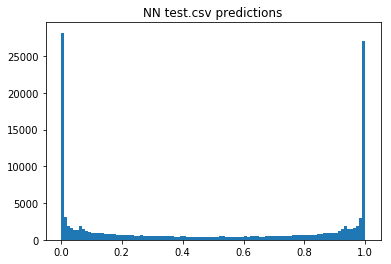

In [10]:
# DISPLAY NN VALIDATION AUC
val_auc = metrics.roc_auc_score(y, oof_preds_NN)
print('NN_CV = OOF_AUC =', round( val_auc,5) )
print('Mean_AUC =', round( np.mean(all_auc_NN),5) )

# PLOT NN TEST PREDICTIONS
plt.hist(test_preds_NN,bins=100)
plt.title('NN test.csv predictions')
plt.show()

# Build 512 SVM
SVM has been shown to score LB 0.928 [here][1]. We will ensemble this with our NN.

[1]: https://www.kaggle.com/cdeotte/support-vector-machine-0-925

In [11]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

cols = [c for c in train.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic']]

from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# INITIALIZE VARIABLES
oof_preds_SVM = np.zeros(len(train))
test_preds_SVM = np.zeros(len(test))

# BUILD 512 SEPARATE MODELS
for i in range(512):
    
    # ONLY TRAIN/PREDICT WHERE WHEEZY-MAGIC EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE SUBSET OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
        
    # STRATIFIED K FOLD
    skf = StratifiedKFold(n_splits=11, random_state=42)
    for train_index, test_index in skf.split(train3, train2['target']):
        
        # MODEL WITH SUPPORT VECTOR MACHINE
        clf = SVC(probability=True,kernel='poly',degree=4,gamma='auto')
        clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof_preds_SVM[idx1[test_index]] = clf.predict_proba(train3[test_index,:])[:,1]
        test_preds_SVM[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits
        
    #if i%10==0: print(i)

SVM_CV = OOF_AUC = 0.92622


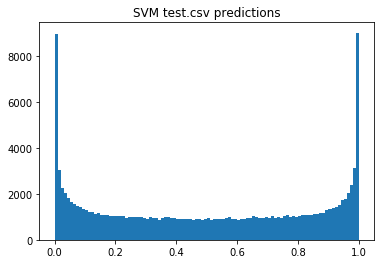

In [12]:
# DISPLAY SVM VALIDATION AUC
val_auc = roc_auc_score(train['target'],oof_preds_SVM)
print('SVM_CV = OOF_AUC =',round(val_auc,5))

# PLOT SVM TEST PREDICTIONS
plt.hist(test_preds_SVM,bins=100)
plt.title('SVM test.csv predictions')
plt.show()

## Ensemble NN and SVM

Ensemble_NN+SVM_CV = OOF_AUC = 0.93609


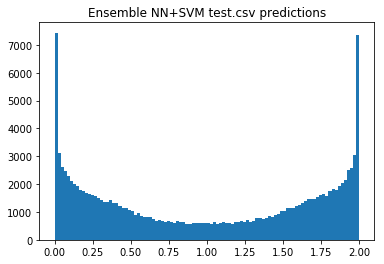

In [13]:
# DISPLAY ENSEMBLE VALIDATION AUC
val_auc = roc_auc_score(train['target'],oof_preds_SVM+oof_preds_NN)
print('Ensemble_NN+SVM_CV = OOF_AUC =',round(val_auc,5))

# PLOT ENSEMBLE TEST PREDICTIONS
plt.hist(test_preds_SVM+test_preds_NN,bins=100)
plt.title('Ensemble NN+SVM test.csv predictions')
plt.show()

# Private Test Dataset Probing
The `test.csv` file that we download only contains the public test dataset. Therefore when we run our code locally or in kaggle kernels and load `test.csv`, we only have `256*512+1` rows. When we submit our kernel for scoring at Kaggle, our same code runs a second time. When our code runs this second time and loads `test.csv`, our code has the full test dataset of `512*512` rows. 

After our code finishes running this second time, the new `submission.csv` is scored and displayed as public LB. (Note that the `submission.csv` file from the first run isn't scored, only the second `submission.csv`). Since `submission.csv` is created after our code "sees" the full test dataset, we can probe the full test dataset and report our findings in our LB score by altering `submission.csv`.

Furthermore we can separate the public and private test dataset. The id column of the dataset was decoded by Kaggle users Linear and Yirun [here][1]. Brilliant work Linear and Yirun! The ids are just the MD5 hash of the row_number as string concatenated with "test" or "train". Therefore we can put all the public test dataset ids into one index allowing us to identify the public/private test dataset and then probe the private test dataset specifically. 

[1]: https://www.kaggle.com/c/instant-gratification/discussion/92634#534306

In [14]:
import hashlib

# CREATE LIST PUBLIC DATASET IDS
public_ids = []
for i in range(256*512+1):
    st = str(i)+"test"
    public_ids.append( hashlib.md5(st.encode()).hexdigest() )
    
# DISPLAY FIRST 5 GENERATED
public_ids[:5]

['1c13f2701648e0b0d46d8a2a5a131a53',
 'ba88c155ba898fc8b5099893036ef205',
 '7cbab5cea99169139e7e6d8ff74ebb77',
 'ca820ad57809f62eb7b4d13f5d4371a0',
 '7baaf361537fbd8a1aaa2c97a6d4ccc7']

In [15]:
# DISPLAY FIRST 5 ACTUAL
test['id'].head()

0    1c13f2701648e0b0d46d8a2a5a131a53
1    ba88c155ba898fc8b5099893036ef205
2    7cbab5cea99169139e7e6d8ff74ebb77
3    ca820ad57809f62eb7b4d13f5d4371a0
4    7baaf361537fbd8a1aaa2c97a6d4ccc7
Name: id, dtype: object

In [16]:
# SEPARATE PUBLIC AND PRIVATE DATASETS
public = test[ test['id'].isin(public_ids) ].copy()
private = test[ ~test.index.isin(public.index) ].copy()

## Determine structure of private dataset
As described [here][1], both the train and public test dataset appear to be 512 datasets combined. Each partial dataset has 256 variables. Therefore there are `131072 = 512 * 216` blocks of data. Each block of data has either standard deviation approx 1.0 or approx 3.75. The blocks with standard deviation 1.0 seem to be **useless** while the blocks with standard deviation 3.75 seem to be **useful**. Does the private test dataset have this same structure?

[1]: https://www.kaggle.com/c/instant-gratification/discussion/92930

In [17]:
# DETERMINE TRAIN DATASET STRUCTURE
useful_train = np.zeros((256,512))
for i in range(512):
    partial = train[ train['wheezy-copper-turtle-magic']==i ]
    useful_train[:,i] = np.std(partial.iloc[:,1:-1], axis=0)
useful_train = useful_train > 1.5

# DETERMINE PUBLIC TEST DATASET STRUCTURE
useful_public = np.zeros((256,512))
for i in range(512):
    partial = public[ public['wheezy-copper-turtle-magic']==i ]
    useful_public[:,i] = np.std(partial.iloc[:,1:], axis=0)
useful_public = useful_public > 1.5

# DETERMINE PRIVATE TEST DATASET STRUCTURE
useful_private = np.zeros((256,512))
for i in range(512):
    partial = private[ private['wheezy-copper-turtle-magic']==i ]
    useful_private[:,i] = np.std(partial.iloc[:,1:], axis=0)
useful_private = useful_private > 1.5

In [18]:
if np.allclose(useful_train,useful_public):
    print('Public dataset has the SAME structure as train')
else:
    print('Public dataset DOES NOT HAVE the same structure as train')

Public dataset has the SAME structure as train


## Report private dataset findings via LB score
If the private dataset has a different structure than the training and public test dataset, we will submit all zero predictions and achieve an LB score of 0.500. If the private dataset has the same structure as training and public test dataset, then we will submit true predictions and achieve an LB score of 0.950.

When we run this locally or in Kaggle kernels, we will create a `submission.csv` that contains all zeros because we do not have the private dataset and therefore the logic determines that private is different (because it isn't present). However when we submit this to Kaggle, we do have the private dataset and it passes the test. As a result we see that this kernel scores LB 0.950 instead of LB 0.500.

In [19]:
sub = pd.read_csv('../input/sample_submission.csv')

if np.allclose(useful_train,useful_public) & np.allclose(useful_train,useful_private):
    print('We are submitting TRUE predictions for LB 0.950')
    sub['target'] = (test_preds_NN + test_preds_SVM) / 2.0
else:
    print('We are submitting ALL ZERO predictions for LB 0.500')
    sub['target'] = np.zeros( len(sub) )
    
sub.to_csv('submission.csv',index=False)

We are submitting ALL ZERO predictions for LB 0.500


# Conclusion
After submitting this to Kaggle, we see that this kernel scored LB 0.950. That implies that when this kernel ran a second time in Kaggle's evaluation procedure, it gained access to the private test dataset and confirmed that the private test dataset has the same datablock structure of usefulness as the training data and public test dataset.

Additionally in this kernel we learned how to utilize the datablock structure to alter the entire dataset thus allowing us to make a single model instead of 512 models. We built a single high scoring NN model.